# Regression on the deer data

**Goal:** In this notebook you will work with TFP. You will set up different regression models that are able to output different conditional probability distribution. You will define all models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You compare the performace of all regression models on the test dataset.  


**Usage:** This notebook should be a case study that you can do by yourself. Try to solve the exercises and then look at the solution and compare your results.

**Dataset:** You work with a dataset that describes deer related car accidents in the years 2002 until 2011 on roads in Bavaria, Germany. It counts the number of deers killed during 30-minute periods anywhere in Bavaria. This dataset has been used previously for the analysis of count data in the statistics literature, and is originally from https://zenodo.org/record/17179. 

**Content:**
* Load and split the dataset 
* Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$
* Fit a poisson regression model in keras and TFP
* Fit a poisson regression model with hidden layers in keras and TFP
* Fit a zero-inflated poisson regression model im keras and TFP
* Fit a zero-inflated poisson regression model with hidden layers in keras and TFP
* Fit a mixture model regression model in keras and TFP
* Fit a mixture model regression model with hidden layers in keras and TFP
* Compare the different models based on the NLL loss on the test dataset

***Hint: Use the previous notebooks form this chapter and the one before as help and reference when you try to solve the exercises***  
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as ss
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from typing import *

tfb = tfp.bijectors
tfd = tfp.distributions
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

In [2]:
df_train = pd.read_feather(os.path.join(data_path, "deer_train.feather"))
df_test = pd.read_feather(os.path.join(data_path, "deer_test.feather"))
data = pd.concat([df_train.assign(is_test=0), df_test.assign(is_test=1)], axis=0, ignore_index=True)
print(data.info())
print(data["is_test"].value_counts())
data[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   wild     175296 non-null  int32   
 1   year     175296 non-null  float64 
 2   time     175296 non-null  float64 
 3   daytime  175296 non-null  category
 4   weekday  175296 non-null  category
 5   is_test  175296 non-null  int64   
dtypes: category(2), float64(2), int32(1), int64(1)
memory usage: 5.0 MB
None
0    140256
1     35040
Name: is_test, dtype: int64


,wild,year,time,daytime,weekday,is_test
0,0,2002.0,0.000000,night.am,Sunday,0
1,0,2002.0,0.020833,night.am,Sunday,0
2,0,2002.0,0.041667,night.am,Sunday,0
3,1,2002.0,0.062500,night.am,Sunday,0
4,3,2002.0,0.083333,night.am,Sunday,0


In [3]:
print(data["daytime"].unique())
print(data["weekday"].unique())

['night.am', 'pre.sunrise.am', 'post.sunrise.am', 'day.am', 'day.pm', 'pre.sunset.pm', 'post.sunset.pm', 'night.pm']
Categories (8, object): ['day.am', 'night.am', 'pre.sunrise.am', 'post.sunrise.am', 'day.pm', 'night.pm', 'pre.sunset.pm', 'post.sunset.pm']
['Sunday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [4]:
label = "wild"
features = ["time", "daytime", "weekday"]
train_cond = data["is_test"] == 0

data["time"] /= (df_train["time"].max() + 1 / 48)
data[label] = data[label].astype("float32")

y_train = data.loc[train_cond, label].values
y_test = data.loc[~train_cond, label].values

X_train = pd.get_dummies(data.loc[train_cond, features]).values
X_test = pd.get_dummies(data.loc[~train_cond, features]).values
del data, df_train, df_test

In [5]:
X_train.shape, X_test.shape

((140256, 16), (35040, 16))

Let's look at the distribution of the target variable: the number of deers killed during that 30-minute period. As you can see the distribution is very skewed. Gor most of the time the nummber of deers killed by a car is, as you would expect, zero. On the other hand you can see that there were two 30-minute periods where 37 and 38 deers died! 

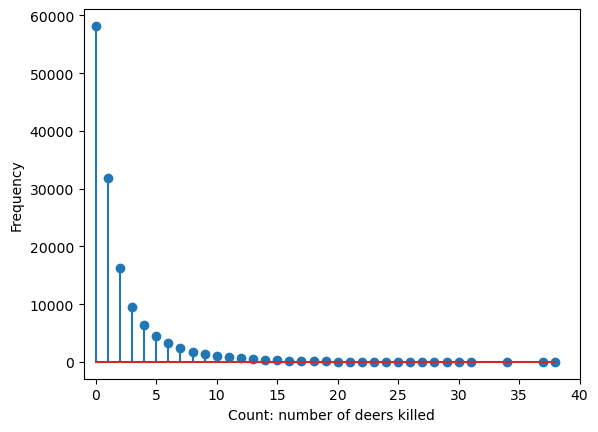

In [6]:
vals, counts = np.unique(y_train, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.show()

### Fitting and comparing different regression models on count data

*Exercise :     
Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$  
Fit a poisson regression model in keras and TFP  
Fit a poisson regression model with hidden layers in keras and TFP  
Fit a zero-inflated poisson regression model im keras and TFP  
Fit a zero-inflated poisson regression model with hidden layers in keras and TFP  
Fit a mixture model regression model in keras and TFP  
Fit a mixture model regression model with hidden layers in keras and TFP*  

*Compare the different models based on the NLL loss on the test dataset*

## Linear regression

In this section you do a standard linear regression in keras and optimize the mean squared error. Afterwards, you can claculate the optimal constant sigma by hand and compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period.

In [7]:
model_lr = Sequential(name="linear_regression") 
model_lr.add(Dense(1, input_dim=(X_train.shape[1]), activation='linear')) 
model_lr.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
model_lr.summary()

Model: "linear_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


2022-10-18 16:44:22.599413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

2022-10-18 16:44:26.893978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
4383/4383 [==============================] - 2s 457us/step - loss: 6.6318 - val_loss: 8.3650
Epoch 2/10
4383/4383 [==============================] - 2s 527us/step - loss: 6.5353 - val_loss: 8.3384
Epoch 3/10
4383/4383 [==============================] - 2s 434us/step - loss: 6.5365 - val_loss: 8.3225
Epoch 4/10
4383/4383 [==============================] - 2s 446us/step - loss: 6.5361 - val_loss: 8.3512
Epoch 5/10
4383/4383 [==============================] - 3s 627us/step - loss: 6.5363 - val_loss: 8.3301
Epoch 6/10
4383/4383 [==============================] - 2s 454us/step - loss: 6.5368 - val_loss: 8.3842
Epoch 7/10
4383/4383 [==============================] - 2s 430us/step - loss: 6.5376 - val_loss: 8.3959
Epoch 8/10
4383/4383 [==============================] - 2s 430us/step - loss: 6.5363 - val_loss: 8.3619
Epoch 9/10
4383/4383 [==============================] - 2s 435us/step - loss: 6.5373 - val_loss: 8.3378
Epoch 10/10
4383/4383 [==============================] - 2s 460u

In [6]:
def get_optimal_sigma(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    n = len(y_true)
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / (n - 2))


def nll(y_true: np.ndarray, y_pred: np.ndarray, sigma: float) -> float:
    return -ss.norm(y_true, sigma).logpdf(y_pred).mean()

In [70]:
# Calculation of the the optimal sigma 
y_train_pred = model_lr.predict(X_train, batch_size=128).flatten()
sigma_hat = get_optimal_sigma(y_train, y_train_pred)
print("Estimated standard deviation: ", sigma_hat)

y_test_pred = model_lr.predict(X_test, batch_size=128).flatten()
print("NLL on train: ", nll(y_train, y_train_pred, sigma_hat))
print("NLL on test: ", nll(y_test, y_test_pred, sigma_hat))

Estimated standard deviation:  2.5563554336089114
NLL on train:  2.357513982259167
NLL on test:  2.4983433644093123


In [7]:
def plot_pred(y_true: np.ndarray, y_pred: np.ndarray, lower: np.ndarray, upper: np.ndarray):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, y_true, alpha=0.3)
    sort_order = np.argsort(y_pred)
    plt.plot(y_pred[sort_order], y_pred[sort_order], c="black")
    plt.plot(y_pred[sort_order], lower[sort_order], linestyle="--", c="black")
    plt.plot(y_pred[sort_order], upper[sort_order], linestyle="--", c="black")
    plt.title('Comparison on the testset')
    plt.xlabel('predicted average of deers killed')
    plt.ylabel('observed number of deers killed')

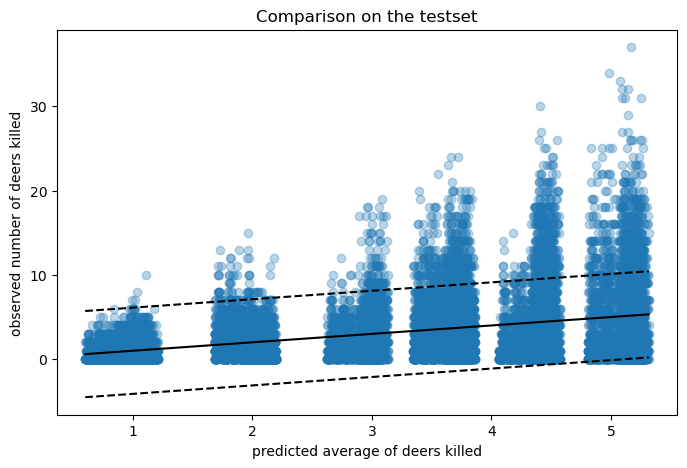

In [71]:
plot_pred(y_test, y_test_pred, y_test_pred - 2 * sigma_hat, y_test_pred + 2 * sigma_hat)

## Poisson Regression

In this section you do a poisson regression with keras and TFP and optimize the NLL. Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. Note that a poisson regression is better suited than a linear regression because we are dealing with count data in this problem.

In [8]:
def NLL(y, dist): 
  return -dist.log_prob(y)

In [9]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, activation="exponential")(inputs) 
p_y = tfp.layers.DistributionLambda(lambda t: tfd.Poisson(rate=t, force_probs_to_zero_outside_support=True))(rate) 
model_p = Model(inputs=inputs, outputs=p_y, name="Poisson") 


model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Instructions for updating:
The `interpolate_nondiscrete` property is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).
Model: "Poisson"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 distribution_lambda (Distri  ((None, 1),              0         
 butionLambda)                (None, 1))                         
                                                                 
Total params: 17
Trainable params: 17
Non-trainable params: 0
_______________

In [10]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 14s 3ms/step - loss: 1.9280 - val_loss: 2.0920
Epoch 2/10
4383/4383 [==============================] - 12s 3ms/step - loss: 1.9188 - val_loss: 2.0747
Epoch 3/10
4383/4383 [==============================] - 12s 3ms/step - loss: 1.9188 - val_loss: 2.1006
Epoch 4/10
4383/4383 [==============================] - 11s 3ms/step - loss: 1.9192 - val_loss: 2.0921
Epoch 5/10
4383/4383 [==============================] - 10s 2ms/step - loss: 1.9190 - val_loss: 2.0728
Epoch 6/10
4383/4383 [==============================] - 12s 3ms/step - loss: 1.9182 - val_loss: 2.0809
Epoch 7/10
4383/4383 [==============================] - 12s 3ms/step - loss: 1.9179 - val_loss: 2.0755
Epoch 8/10
4383/4383 [==============================] - 12s 3ms/step - loss: 1.9183 - val_loss: 2.0915
Epoch 9/10
4383/4383 [==============================] - 12s 3ms/step - loss: 1.9185 - val_loss: 2.1196
Epoch 10/10
4383/4383 [==============================] - 12s 3ms/step - l

In [11]:
NLL_train = model_p.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_p.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.9130833148956299
NLL on test: 2.084712266921997


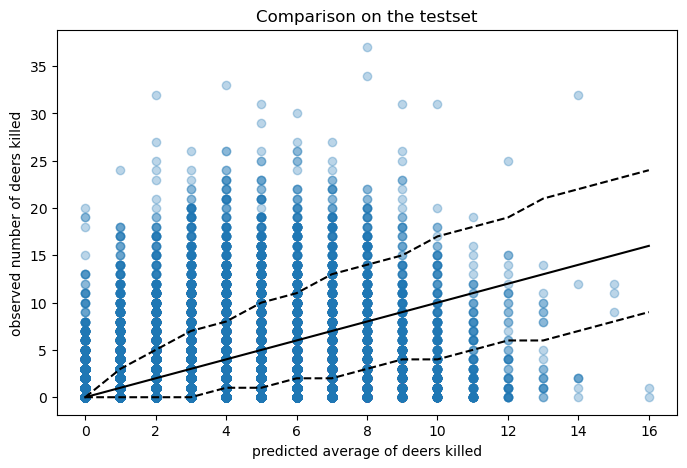

In [12]:
y_test_pred = model_p.predict(X_test, batch_size=128).flatten()
lower = ss.poisson.ppf(0.025, y_test_pred)
upper = ss.poisson.ppf(0.975, y_test_pred)

plot_pred(y_test, y_test_pred, lower, upper)

## Poisson Regression with hidden layers

In this section you do a poisson regression with keras and TFP and optimize the NLL. This time we add some hidden layers in between. Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. Note that a poisson regression is better suited than a linear regression because we are dealing with count data in this problem.

In [13]:
inputs = Input(shape=(X_train.shape[1],))  
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
rate = Dense(1, activation="exponential")(x) 
p_y = tfp.layers.DistributionLambda(lambda t: tfd.Poisson(rate=t, force_probs_to_zero_outside_support=True))(rate) 
model_p_h = Model(inputs=inputs, outputs=p_y, name="Poisson_hidden") 

model_p_h.compile(Adam(learning_rate=0.01), loss=NLL)
model_p_h.summary()

Model: "Poisson_hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 100)               1700      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
 distribution_lambda_1 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                    

In [14]:
hist_p_h = model_p_h.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 18s 4ms/step - loss: 1.9086 - val_loss: 2.0442
Epoch 2/10
4383/4383 [==============================] - 16s 4ms/step - loss: 1.8955 - val_loss: 2.0403
Epoch 3/10
4383/4383 [==============================] - 16s 4ms/step - loss: 1.8924 - val_loss: 2.0392
Epoch 4/10
4383/4383 [==============================] - 16s 4ms/step - loss: 1.8927 - val_loss: 2.0432
Epoch 5/10
4383/4383 [==============================] - 17s 4ms/step - loss: 1.8907 - val_loss: 2.0428
Epoch 6/10
4383/4383 [==============================] - 17s 4ms/step - loss: 1.8909 - val_loss: 2.0383
Epoch 7/10
4383/4383 [==============================] - 17s 4ms/step - loss: 1.8892 - val_loss: 2.0757
Epoch 8/10
4383/4383 [==============================] - 17s 4ms/step - loss: 1.8891 - val_loss: 2.0502
Epoch 9/10
4383/4383 [==============================] - 16s 4ms/step - loss: 1.8886 - val_loss: 2.0556
Epoch 10/10
4383/4383 [==============================] - 17s 4ms/step - l

In [15]:
NLL_train = model_p_h.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_p_h.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.8871345520019531
NLL on test: 2.0725221633911133


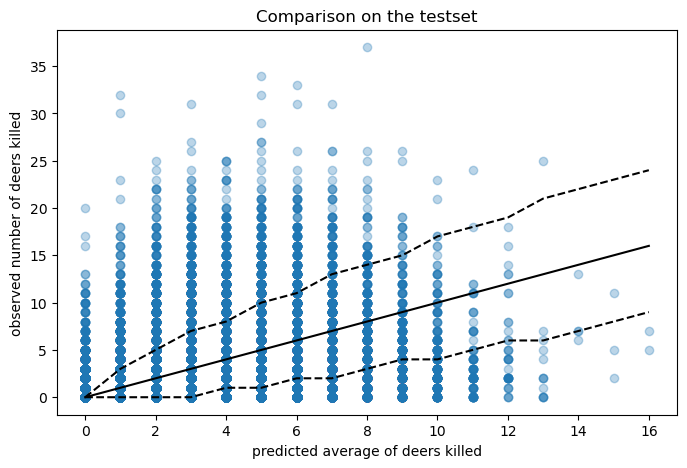

In [17]:
y_test_pred = model_p_h.predict(X_test, batch_size=128).flatten()
lower = ss.poisson.ppf(0.025, y_test_pred)
upper = ss.poisson.ppf(0.975, y_test_pred)

plot_pred(y_test, y_test_pred, lower, upper)

## Zero inflated Poisson Regression

In this section you do a zero infalted poisson regression with keras and TFP and optimize the NLL. A zero inflated poisson regression should be better suited because for most of the time the number of killed deer in a 30-minutes period is zero. You define ZIP distribution in TFP with the two parameters :
* rate: which defines the rate $\lambda$ of a Poisson process
* s: the probability to pick Poisson process (accordingly the zero-generating process is picked with probability 1-s)

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [18]:
def zero_inf(out):
    rate = K.exp(out[:, 0])
    s = K.sigmoid(out[:, 1:2])
    probs = tf.concat([1 - s, s], axis=1)
    return tfd.Mixture(
        cat=tfd.Categorical(probs=probs), 
        components=[tfd.Deterministic(loc=K.zeros_like(rate)), 
                    tfd.Poisson(rate=rate, force_probs_to_zero_outside_support=True)])

inputs = Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs)
dist = tfp.layers.DistributionLambda(zero_inf)(out)
model_zip = Model(inputs=inputs, outputs=dist, name="ZIPossion")

model_zip.compile(Adam(learning_rate=0.01), loss=NLL)
model_zip.summary()

Model: "ZIPossion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_5 (Dense)             (None, 2)                 34        
                                                                 
 distribution_lambda_2 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                                 
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [19]:
hist_zip = model_zip.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 21s 5ms/step - loss: 1.8066 - val_loss: 1.9402
Epoch 2/10
4383/4383 [==============================] - 21s 5ms/step - loss: 1.7973 - val_loss: 1.9373
Epoch 3/10
4383/4383 [==============================] - 21s 5ms/step - loss: 1.7968 - val_loss: 1.9254
Epoch 4/10
4383/4383 [==============================] - 21s 5ms/step - loss: 1.7968 - val_loss: 1.9293
Epoch 5/10
4383/4383 [==============================] - 21s 5ms/step - loss: 1.7971 - val_loss: 1.9301
Epoch 6/10
4383/4383 [==============================] - 21s 5ms/step - loss: 1.7973 - val_loss: 1.9639
Epoch 7/10
4383/4383 [==============================] - 18s 4ms/step - loss: 1.7971 - val_loss: 1.9433
Epoch 8/10
4383/4383 [==============================] - 20s 5ms/step - loss: 1.7968 - val_loss: 1.9374
Epoch 9/10
4383/4383 [==============================] - 19s 4ms/step - loss: 1.7966 - val_loss: 1.9541
Epoch 10/10
4383/4383 [==============================] - 21s 5ms/step - l

In [20]:
NLL_train = model_zip.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_zip.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.7922477722167969
NLL on test: 1.9295958280563354


100%|██████████████████████████████████████████████████████████████████████████████| 3504/3504 [03:13<00:00, 18.11it/s]


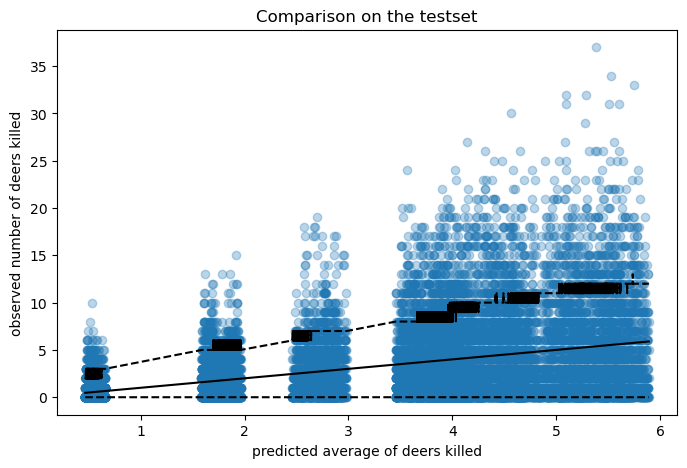

In [44]:
y_test_pred = model_zip(X_test).mean().numpy()
upper = np.zeros_like(y_test)
lower = np.zeros_like(y_test)
batch_size = 10

for i in tqdm(range(0, len(X_test) // batch_size)):
    slice_ = slice(i * batch_size, (i + 1) * batch_size)
    samples = model_zip(X_test[slice_]).sample(5000).numpy()
    upper[slice_] = np.quantile(samples, 0.975, axis=0)
    lower[slice_] = np.quantile(samples, 0.025, axis=0)

plot_pred(y_test, y_test_pred, lower, upper)

## Zero inflated Poisson Regression with hidden layers

In this section you do a zero infalted poisson regression with keras and TFP and optimize the NLL. A zero inflated poisson regression should be better suited because for most of the time the number of killed deer in a 30-minutes period is zero. This time you also add some hidden layers in between. You define ZIP distribution in TFP with the two parameters :
* the probability 1-p with which zeros are produced
* the rate of a Poisson distribution with probability p.

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [45]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
out = Dense(2)(x)
dist = tfp.layers.DistributionLambda(zero_inf)(out)
model_zip_h = Model(inputs=inputs, outputs=dist, name="ZIPossion_hidden")

model_zip_h.compile(Adam(learning_rate=0.01), loss=NLL)
model_zip_h.summary()

Model: "ZIPossion_hidden"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_6 (Dense)             (None, 100)               1700      
                                                                 
 dense_7 (Dense)             (None, 100)               10100     
                                                                 
 dense_8 (Dense)             (None, 10)                1010      
                                                                 
 dense_9 (Dense)             (None, 2)                 22        
                                                                 
 distribution_lambda_3 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                  

In [46]:
hist_zip_h = model_zip_h.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 26s 6ms/step - loss: 1.8011 - val_loss: 1.9233
Epoch 2/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7872 - val_loss: 1.9170
Epoch 3/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7853 - val_loss: 1.9075
Epoch 4/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7849 - val_loss: 1.9293
Epoch 5/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7845 - val_loss: 1.9163
Epoch 6/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7847 - val_loss: 1.9205
Epoch 7/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7837 - val_loss: 1.9086
Epoch 8/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7848 - val_loss: 1.9312
Epoch 9/10
4383/4383 [==============================] - 27s 6ms/step - loss: 1.7856 - val_loss: 1.9096
Epoch 10/10
4383/4383 [==============================] - 28s 6ms/step - l

In [47]:
NLL_train = model_zip_h.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_zip_h.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.7816749811172485
NLL on test: 1.9209314584732056


100%|██████████████████████████████████████████████████████████████████████████████| 3504/3504 [03:15<00:00, 17.92it/s]


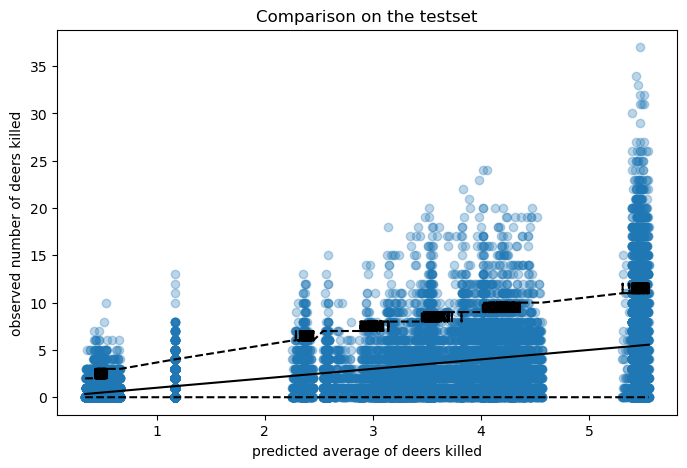

In [50]:
y_test_pred = model_zip_h(X_test).mean().numpy()
upper = np.zeros_like(y_test)
lower = np.zeros_like(y_test)
batch_size = 10

for i in tqdm(range(0, len(X_test) // batch_size)):
    slice_ = slice(i * batch_size, (i + 1) * batch_size)
    samples = model_zip_h(X_test[slice_]).sample(5000).numpy()
    upper[slice_] = np.quantile(samples, 0.975, axis=0)
    lower[slice_] = np.quantile(samples, 0.025, axis=0)

plot_pred(y_test, y_test_pred, lower, upper)

## Regression with a discretized logistic mixture distribution

In this section you do a regression with a discretized logistic mixture distribution in keras and TFP and optimize the NLL.  
Fist you define the quant_mixture_logistic function and then you can use it with the tfp.layers.DistributionLambda layer as the output for your model.  
See aslo: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution. For each mixture component the NN needs to estimate three parameters: The location of the component, the spread and how much the component is weighted. Note that the output should be without activation (as it is default in Keras).

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [9]:
def quant_mixture_logistic(out, bits: int = 8, num: int = 3): 
    loc, un_scale, logits = tf.split(out, num_or_size_splits=num, axis=-1)
    scale = tf.nn.softplus(un_scale)
    discretized_logistic_dist = tfd.QuantizedDistribution(
        distribution=tfd.TransformedDistribution(distribution=tfd.Logistic(loc=loc, scale=scale), bijector=tfb.Shift(-0.5)),
        low=0., high=2**bits - 1.)
    mixture_dist = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(logits=logits), components_distribution=discretized_logistic_dist)
    return mixture_dist

In [10]:
inputs = Input(shape=(X_train.shape[1],))  
out = Dense(9)(inputs)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)
model_q = Model(inputs=inputs, outputs=p_y)

model_q.compile(optimizer=Adam(learning_rate=0.01), loss=NLL)
model_q.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense (Dense)               (None, 9)                 153       
                                                                 
 distribution_lambda (Distri  ((None,),                0         
 butionLambda)                (None,))                           
                                                                 
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


In [11]:
hist_q = model_q.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 32s 7ms/step - loss: 1.6300 - val_loss: 1.7039
Epoch 2/10
4383/4383 [==============================] - 32s 7ms/step - loss: 1.6164 - val_loss: 1.7130
Epoch 3/10
4383/4383 [==============================] - 37s 8ms/step - loss: 1.6157 - val_loss: 1.7157
Epoch 4/10
4383/4383 [==============================] - 33s 8ms/step - loss: 1.6157 - val_loss: 1.7124
Epoch 5/10
4383/4383 [==============================] - 34s 8ms/step - loss: 1.6153 - val_loss: 1.7066
Epoch 6/10
4383/4383 [==============================] - 38s 9ms/step - loss: 1.6151 - val_loss: 1.7039
Epoch 7/10
4383/4383 [==============================] - 38s 9ms/step - loss: 1.6156 - val_loss: 1.7049
Epoch 8/10
4383/4383 [==============================] - 30s 7ms/step - loss: 1.6152 - val_loss: 1.7035
Epoch 9/10
4383/4383 [==============================] - 38s 9ms/step - loss: 1.6147 - val_loss: 1.7031
Epoch 10/10
4383/4383 [==============================] - 34s 8ms/step - l

In [12]:
NLL_train = model_q.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_q.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.6140174865722656
NLL on test: 1.7053533792495728


100%|██████████████████████████████████████████████████████████████████████████████| 3504/3504 [01:58<00:00, 29.58it/s]


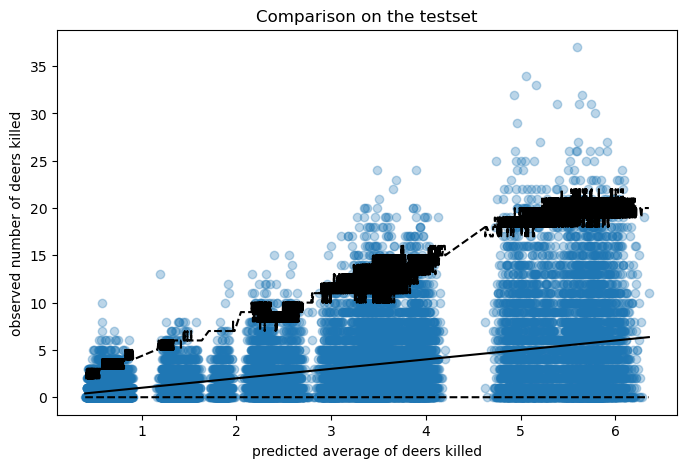

In [14]:
# Note that there is no mean function for the QuantizedDistribution, therefore we take mean of samples.

y_test_pred = np.zeros_like(y_test)
upper = np.zeros_like(y_test)
lower = np.zeros_like(y_test)
batch_size = 10

for i in tqdm(range(0, len(X_test) // batch_size)):
    slice_ = slice(i * batch_size, (i + 1) * batch_size)
    samples = model_q(X_test[slice_]).sample(5000).numpy().T
    y_test_pred[slice_] = samples.mean(axis=1)
    upper[slice_] = np.quantile(samples, 0.975, axis=1)
    lower[slice_] = np.quantile(samples, 0.025, axis=1)

plot_pred(y_test, y_test_pred, lower, upper)

## Regression with a discretized logistic mixture distribution and hidden layers

In this section you do a regression with a discretized logistic mixture distribution in keras and TFP and optimize the NLL. This time you will add some hidden layers in between.  
Fist you define the quant_mixture_logistic function and then you can use it with the tfp.layers.DistributionLambda layer as the output for your model.  
See aslo: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/QuantizedDistribution. For each mixture component the NN needs to estimate three parameters: The location of the component, the spread and how much the component is weighted. Note that the output should be without activation (as it is default in Keras).

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [15]:
inputs = Input(shape=(X_train.shape[1],))
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
out = Dense(9)(x)
p_y = tfp.layers.DistributionLambda(quant_mixture_logistic)(out)

model_q_h = Model(inputs=inputs, outputs=p_y)
model_q_h.compile(optimizer=Adam(learning_rate=0.01), loss=NLL)
model_q_h.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 100)               1700      
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 10)                1010      
                                                                 
 dense_4 (Dense)             (None, 9)                 99        
                                                                 
 distribution_lambda_1 (Dist  ((None,),                0         
 ributionLambda)              (None,))                           
                                                           

In [16]:
hist_q_h = model_q_h.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6265 - val_loss: 1.7010
Epoch 2/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6167 - val_loss: 1.7000
Epoch 3/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6160 - val_loss: 1.7049
Epoch 4/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6153 - val_loss: 1.7084
Epoch 5/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6154 - val_loss: 1.7042
Epoch 6/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6157 - val_loss: 1.7013
Epoch 7/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6154 - val_loss: 1.7010
Epoch 8/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6157 - val_loss: 1.7012
Epoch 9/10
4383/4383 [==============================] - 45s 10ms/step - loss: 1.6151 - val_loss: 1.7031
Epoch 10/10
4383/4383 [==============================] - 45s 10m

In [17]:
NLL_train = model_q_h.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_q_h.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.620921015739441
NLL on test: 1.712829351425171


100%|██████████████████████████████████████████████████████████████████████████████| 3504/3504 [02:00<00:00, 29.15it/s]


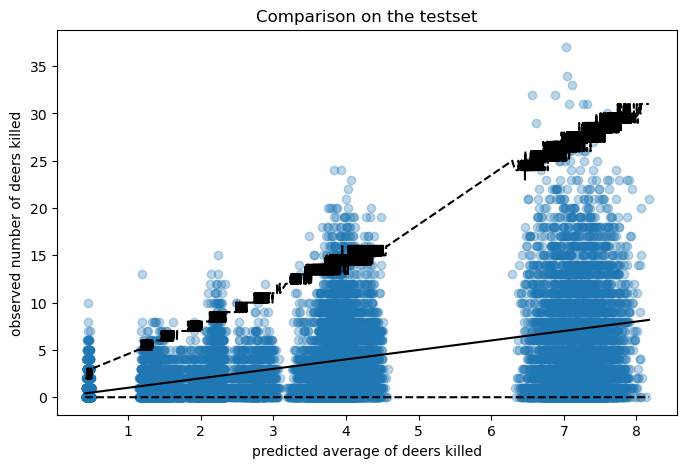

In [18]:
y_test_pred = np.zeros_like(y_test)
upper = np.zeros_like(y_test)
lower = np.zeros_like(y_test)
batch_size = 10

for i in tqdm(range(0, len(X_test) // batch_size)):
    slice_ = slice(i * batch_size, (i + 1) * batch_size)
    samples = model_q_h(X_test[slice_]).sample(5000).numpy().T
    y_test_pred[slice_] = samples.mean(axis=1)
    upper[slice_] = np.quantile(samples, 0.975, axis=1)
    lower[slice_] = np.quantile(samples, 0.025, axis=1)

plot_pred(y_test, y_test_pred, lower, upper)